In [70]:
import networkx as nx
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [72]:
plt.rcParams["figure.figsize"] = (20,3)

In [73]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [74]:
DATASET = DatasetSchema.load_schema('ucidata-zachary')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [75]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: False


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [76]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [77]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


In [78]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

No edge timestamp data available


# Global Statistics

In [79]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 34
Number of Edges: 156
Density: 0.13903743315508021


In [80]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [81]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 9.176470588235293
Median Degree: 6.0


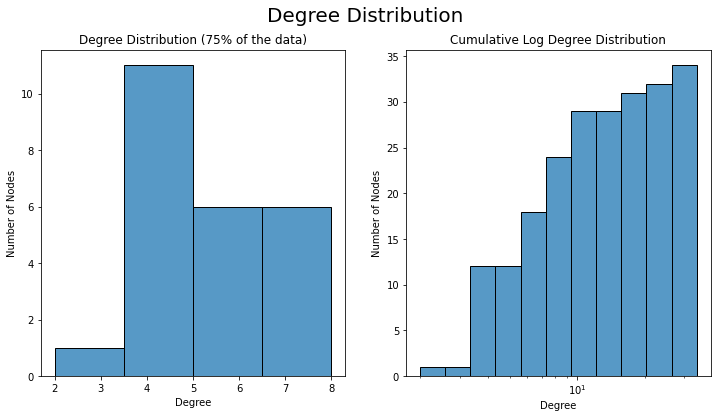

In [82]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [83]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,34,33
1,32,0
2,24,32
3,20,2
4,18,1
5,12,3
6,12,31
7,10,23
8,10,8
9,10,13


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [84]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [85]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.569
Diameter: 5


In [86]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,34.000000,34.000000,34.000000,34.000000,33.000000
mean,0.139037,0.048295,0.146411,0.029412,0.587931
std,0.117509,0.097550,0.090649,0.022129,0.337614
min,0.030303,0.000000,0.023635,0.009565,0.000000
25%,0.060606,0.000000,0.080673,0.014580,0.333333
50%,0.090909,0.000000,0.102041,0.021979,0.500000
75%,0.151515,0.051739,0.186967,0.029708,1.000000
max,0.515152,0.438773,0.373371,0.100918,1.000000


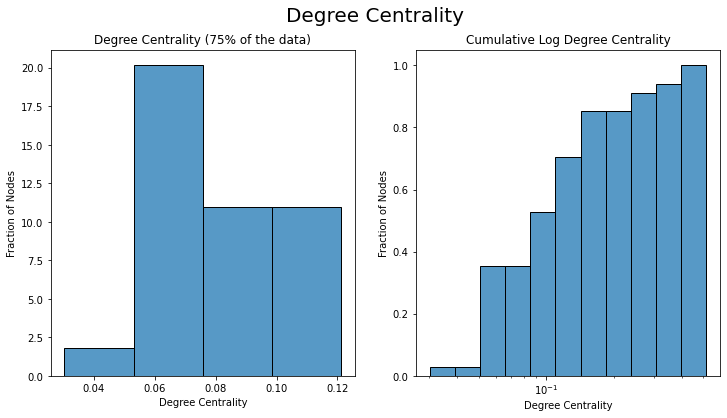

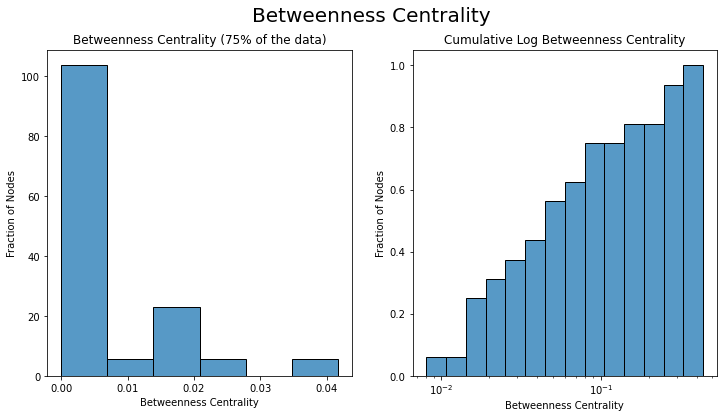

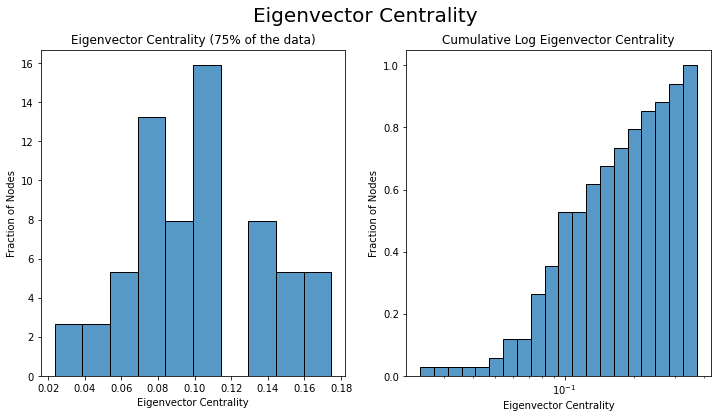

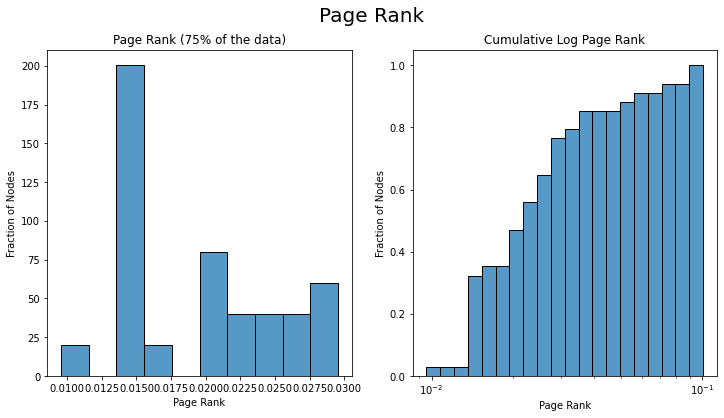

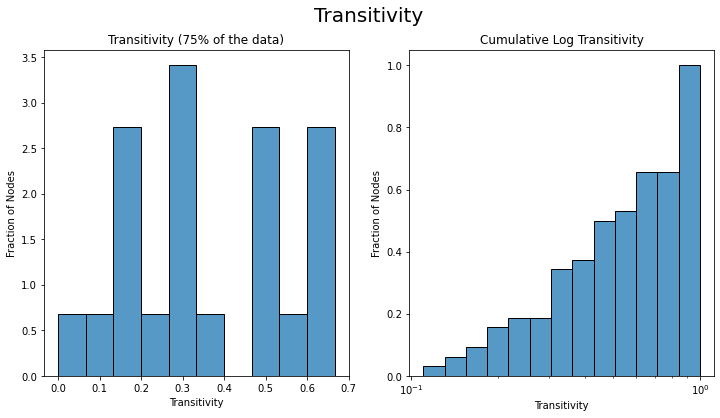

In [87]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [88]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.515152,33,0.438773,33,0.373371,33,0.100918,33,1.0,21
1,0.484848,0,0.284407,32,0.355483,0,0.097002,0,1.0,22
2,0.363636,32,0.255966,0,0.317189,2,0.071692,32,1.0,15
3,0.303030,2,0.142382,2,0.308651,32,0.057078,2,1.0,14
4,0.272727,1,0.103388,27,0.265954,1,0.052878,1,1.0,26
5,0.181818,31,0.096054,31,0.227405,8,0.037157,31,1.0,20
6,0.181818,3,0.064036,8,0.226470,13,0.035861,3,1.0,17
7,0.151515,13,0.058849,25,0.211174,3,0.031521,23,1.0,16
8,0.151515,23,0.055093,13,0.191036,31,0.029765,8,1.0,12
9,0.151515,8,0.041677,19,0.174760,30,0.029536,13,1.0,18


## Connected Components Statistics

In [89]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 34


Text(0.5, 1.0, 'Connected Components')

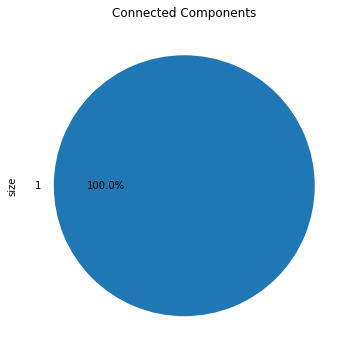

In [90]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [91]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
Pupil,Pupil,34,9.176471,6.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

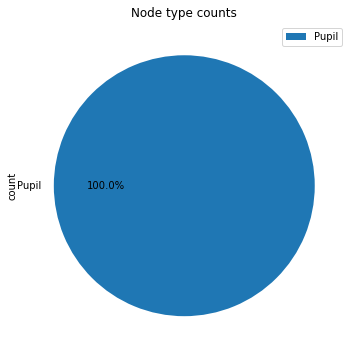

In [92]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

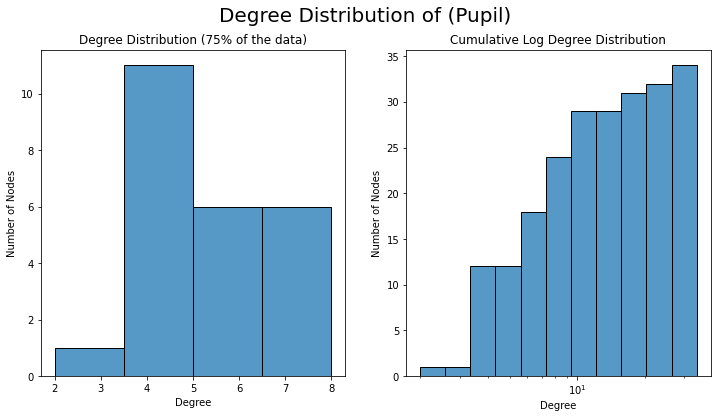

In [93]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [94]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Pupil)


,value,label
0,34,33
1,32,0
2,24,32
3,20,2
4,18,1
5,12,3
6,12,31
7,10,23
8,10,8
9,10,13


### Edge Type Statistics

In [95]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 1


,type,count
INTERACTS,INTERACTS,156


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

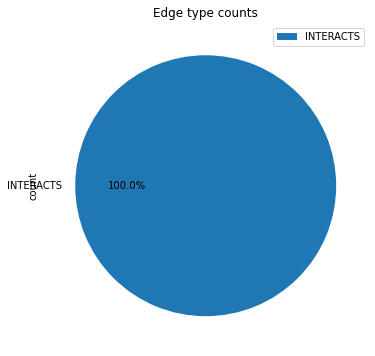

In [96]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [97]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [98]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Pupil


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.515152,33,0.438773,33,0.373371,33,0.100918,33,1.0,17
1,0.484848,0,0.284407,32,0.355483,0,0.097002,0,1.0,12
2,0.363636,32,0.255966,0,0.317189,2,0.071692,32,1.0,26
3,0.303030,2,0.142382,2,0.308651,32,0.057078,2,1.0,22
4,0.272727,1,0.103388,27,0.265954,1,0.052878,1,1.0,21
5,0.181818,3,0.096054,31,0.227405,8,0.037157,31,1.0,20
6,0.181818,31,0.064036,8,0.226470,13,0.035861,3,1.0,18
7,0.151515,23,0.058849,25,0.211174,3,0.031521,23,1.0,15
8,0.151515,8,0.055093,13,0.191036,31,0.029765,8,1.0,14
9,0.151515,13,0.041677,19,0.174760,30,0.029536,13,1.0,16


# Clustering

## No Clustering Modularity

In [99]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [100]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.3952169625246548
Number of communities: 4


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

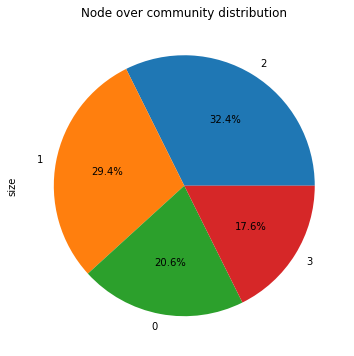

In [101]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [102]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.484848,0,0.255966,0,0.355483,0,0.097002,0,1.000000,16
1,0.121212,5,0.016098,5,0.079481,5,0.029113,5,0.666667,4
2,0.121212,6,0.016098,6,0.079481,6,0.029113,6,0.666667,10
3,0.090909,4,0.000000,4,0.075966,4,0.021979,4,0.500000,5
4,0.090909,10,0.000000,10,0.075966,10,0.021979,10,0.500000,6
5,0.060606,16,0.000000,11,0.052854,11,0.016785,16,0.150000,0
6,0.030303,11,0.000000,16,0.023635,16,0.009565,11,NaN,11


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.303030,2,0.142382,2,0.317189,2,0.057078,2,1.000000,7
1,0.272727,1,0.055093,13,0.265954,1,0.052878,1,1.000000,12
2,0.181818,3,0.041677,19,0.226470,13,0.035861,3,1.000000,17
3,0.151515,13,0.025758,1,0.211174,3,0.029536,13,1.000000,21
4,0.121212,7,0.008049,3,0.170955,7,0.024491,7,0.666667,3
5,0.090909,19,0.000000,7,0.147911,19,0.019604,19,0.600000,13
6,0.060606,9,0.000000,9,0.102675,9,0.014645,12,0.333333,1
7,0.060606,12,0.000000,12,0.092397,17,0.014559,17,0.333333,19
8,0.060606,17,0.000000,17,0.092397,21,0.014559,21,0.244444,2
9,0.060606,21,0.000000,21,0.084252,12,0.014309,9,0.000000,9


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.515152,33,0.438773,33,0.373371,33,0.100918,33,1.000000,14
1,0.363636,32,0.284407,32,0.308651,32,0.071692,32,1.000000,15
2,0.151515,8,0.064036,8,0.227405,8,0.029765,8,1.000000,18
3,0.121212,29,0.019318,30,0.174760,30,0.026287,29,1.000000,20
4,0.121212,30,0.016098,29,0.134965,29,0.024589,30,1.000000,22
5,0.060606,14,0.000000,14,0.101406,14,0.015043,26,1.000000,26
6,0.060606,15,0.000000,15,0.101406,15,0.014535,14,0.666667,29
7,0.060606,18,0.000000,18,0.101406,18,0.014535,15,0.500000,8
8,0.060606,20,0.000000,20,0.101406,20,0.014535,18,0.500000,30
9,0.060606,22,0.000000,22,0.101406,22,0.014535,20,0.196970,32


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.181818,31,0.103388,27,0.191036,31,0.037157,31,0.400000,23
1,0.151515,23,0.096054,31,0.150123,23,0.031521,23,0.333333,24
2,0.121212,27,0.058849,25,0.133479,27,0.025639,27,0.333333,25
3,0.090909,24,0.000000,23,0.131079,28,0.021075,24,0.333333,28
4,0.090909,25,0.000000,24,0.059208,25,0.021006,25,0.200000,31
5,0.090909,28,0.000000,28,0.057054,24,0.019573,28,0.166667,27


No node timestamp data available


### Label Propagation

In [103]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.39907955292570685
Number of communities: 3


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

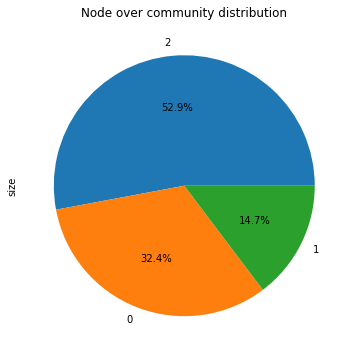

In [104]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [105]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.484848,0,0.255966,0,0.355483,0,0.097002,0,1.000000,7
1,0.303030,2,0.142382,2,0.317189,2,0.057078,2,1.000000,12
2,0.272727,1,0.055093,13,0.265954,1,0.052878,1,1.000000,17
3,0.181818,3,0.041677,19,0.226470,13,0.035861,3,1.000000,21
4,0.151515,13,0.025758,1,0.211174,3,0.029536,13,0.666667,3
5,0.121212,7,0.008049,3,0.170955,7,0.024491,7,0.600000,13
6,0.090909,19,0.000000,7,0.147911,19,0.019604,19,0.333333,1
7,0.060606,12,0.000000,11,0.092397,17,0.014645,12,0.333333,19
8,0.060606,17,0.000000,12,0.092397,21,0.014559,17,0.244444,2
9,0.060606,21,0.000000,17,0.084252,12,0.014559,21,0.150000,0


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.121212,5,0.016098,5,0.079481,5,0.029113,5,1.000000,16
1,0.121212,6,0.016098,6,0.079481,6,0.029113,6,0.666667,4
2,0.090909,4,0.000000,4,0.075966,4,0.021979,4,0.666667,10
3,0.090909,10,0.000000,10,0.075966,10,0.021979,10,0.500000,5
4,0.060606,16,0.000000,16,0.023635,16,0.016785,16,0.500000,6


No timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.515152,33,0.438773,33,0.373371,33,0.100918,33,1.000000,14
1,0.363636,32,0.284407,32,0.308651,32,0.071692,32,1.000000,15
2,0.181818,31,0.103388,27,0.227405,8,0.037157,31,1.000000,18
3,0.151515,23,0.096054,31,0.191036,31,0.031521,23,1.000000,20
4,0.151515,8,0.064036,8,0.174760,30,0.029765,8,1.000000,22
5,0.121212,27,0.058849,25,0.150123,23,0.026287,29,1.000000,26
6,0.121212,29,0.019318,30,0.134965,29,0.025639,27,0.666667,29
7,0.121212,30,0.016098,29,0.133479,27,0.024589,30,0.500000,8
8,0.090909,24,0.000000,20,0.131079,28,0.021075,24,0.500000,30
9,0.090909,28,0.000000,22,0.102675,9,0.021006,25,0.400000,23


No timestamp data available
